In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import rankdata
from sklearn.metrics import roc_auc_score
from scipy.optimize import minimize
from scipy.special import expit as sigmoid
from scipy.special import logit
from pathlib import Path
import seaborn as sns
from numba import jit, njit
from joblib import Parallel, delayed
from scipy.optimize import minimize, fsolve
from functools import partial
import cma
from sklearn.preprocessing import PolynomialFeatures

COMP_NAME = "g2net-gravitational-wave-detection"
# INPUT_PATH = f"../input/{COMP_NAME}/"
# OUTPUT_PATH = f"../input/ensemble-0916/"
INPUT_PATH = "/mnt/storage_dimm2/kaggle_data/g2net-gravitational-wave-detection"
OUTPUT_PATH = "/mnt/storage_dimm2/kaggle_data/g2net-gravitational-wave-detection/stacking"

In [2]:
gt = pd.read_csv(INPUT_PATH + "/" + "training_labels.csv")
names = [
    "A-RN200",
    "A-B5PL",
    "A-B5",
    "A-V2M",
    "A-1D",
    "A-CWT",
    "A-B3",
    "A-B3CWT",
    "I-B3",
    "I-B4",
    "I-B5",
    "I-B7",
    "I-IV3",
    "R-1D",
    "R-V2SD",
    "R-V2SD2",
    "R-V2",
    "R-V2SDCBAM",
    "R-133",  # "R-137",
    "V-V2SD",
    "V_3D",
    "M-1D",
    "M-1DS32",
    "M-1DC16",
    "M-SD16",
    "M-SD32",
]

model_names = [
    "resnet-200d",
    "eff-B5",
    "eff-b5",
    "ef-v2M",
    "1dCNN",
    "CWT",
    "B3",
    "B3CWT",
]
oof_files = [
    "oofs_20210830-191530_CV-0.87733.csv",  # ResNet200d
    "oofs_20210918-112751_CV-0.87870.csv",  # EfficientNet B5
    "oofs_20210901-130913_CV-0.87749.csv",  # EfficientNet B5
    "oofs_20210902-200442_CV-0.87733.csv",  # EfficientNet V2 M
    "oofs_20210915-003751_CV-0.87393.csv",  # 1D CNN
    "oofs_20210915-072731_CV-0.87707.csv",  # CWT
    "oofs_20210923-103832_CV-0.87829.csv",  # B3
    "oofs_20210925-085935_CV-0.87818.csv",  # B3-CWT
]

oof_paths = [
    OUTPUT_PATH
    + "/"
    + (model_names[i] + "-" + f.split("_")[1] + "_predictions")
    + "/"
    + f
    for i, f in enumerate(oof_files)
]
sub_paths = [
    OUTPUT_PATH
    + "/"
    + (model_names[i] + "-" + f.split("_")[1] + "_predictions")
    + "/"
    + f.replace("oofs", "sub")
    for i, f in enumerate(oof_files)
]
# test_paths = [OUTPUT_PATH / (model_names[i] + "-" + f.split("_")[1]+"_predictions") / f.replace("oofs", "test") for i,f in enumerate(oof_files)]

oof_paths_other = [
    OUTPUT_PATH + "/oof_effB3-512-PL-float.csv",
    OUTPUT_PATH + "/oof_effB4-512-PL-CV087755.csv",
    OUTPUT_PATH + "/oof_effB5-512-PL-CV087728.csv",
    OUTPUT_PATH + "/oof_w_effB7-512-SKF.csv",
    OUTPUT_PATH + "/oof_inception_v3_PL_CV087466.csv",
    OUTPUT_PATH + "/oof_1DCNN_richard.csv",
    OUTPUT_PATH + "/oof_112nd_V2SD_PL.csv",
    OUTPUT_PATH + "/oof_121st_V2SD.csv",
    OUTPUT_PATH + "/oof_122nd_V2.csv",
    OUTPUT_PATH + "/oof_124th_V2SDCBAM_tta_blend.csv",
    OUTPUT_PATH + "/oof_133rd_V2SD_PL_4ep_2em3lr_32ch_vf_sc01_drop05.csv",
    # OUTPUT_PATH + "/oof_137th_tta_blend.csv",
    # OUTPUT_PATH +  "/oof_V2_c16_sGW_vflip_sc01_PL_CV88163.csv",
    OUTPUT_PATH + "/oof_V2SD_sGW_vflip_sc01_PL_CV88003.csv",
    # OUTPUT_PATH +  "/oof_resnet34-sGW2ep-PL-sc01_CV87764.csv",
    OUTPUT_PATH + "/oof_1D2D_1ep_CV88153.csv",
    OUTPUT_PATH + "/oof_1D_adjust_MC_CV88158.csv",
    OUTPUT_PATH + "/oof_1D_adjust_Split32_MC_CV88149.csv",
    OUTPUT_PATH + "/oof_1D_adjust_c16_MC_CV88170.csv",
    OUTPUT_PATH + "/oof_1D_adjust_SD16_MC_CV88164.csv",
    OUTPUT_PATH + "/oof_1D_adjust_SD32_MC_CV88185.csv",
]

sub_paths_other = [
    OUTPUT_PATH + "/submission_effB3-512-PL-CV0877245.csv",
    OUTPUT_PATH + "/submission_effB4-512-PL-CV087755.csv",
    OUTPUT_PATH + "/submission_effB5-512-PL-CV087728.csv",
    OUTPUT_PATH + "/submission_w_effB7-512-SKF.csv",
    OUTPUT_PATH + "/submission_inception_v3_PL_CV087466.csv",
    OUTPUT_PATH + "/submission_main_35th_GeM_vflip_shuffle01.csv",
    OUTPUT_PATH + "/submission_112nd_V2SD_PL.csv",
    OUTPUT_PATH + "/submission_121st_V2SD.csv",
    OUTPUT_PATH + "/submission_122nd_V2.csv",
    OUTPUT_PATH + "/submission_124th_V2SDCBAM_tta_blend.csv",
    OUTPUT_PATH + "/submission_133rd_V2SD_PL_4ep_2em3lr_32ch_vf_sc01_drop05.csv",
    # OUTPUT_PATH + "/submission_137th_tta_blend.csv",
    # OUTPUT_PATH +  "/submission_V2_c16_sGW_vflip_sc01_PL_CV88163.csv",
    OUTPUT_PATH + "/submission_V2SD_sGW_vflip_sc01_PL_CV88003.csv",
    # OUTPUT_PATH +  "/submission_resnet34-sGW2ep-PL-sc01_CV87764.csv",
    OUTPUT_PATH + "/submission_1D2D_1ep_CV88153.csv",
    OUTPUT_PATH + "/submission_1D_adjust_MC_CV88158.csv",
    OUTPUT_PATH + "/submission_1D_adjust_Split32_MC_CV88149.csv",
    OUTPUT_PATH + "/submission_1D_adjust_c16_MC_CV88170.csv",
    OUTPUT_PATH + "/submission_1D_adjust_SD16_MC_CV88164.csv",
    OUTPUT_PATH + "/submission_1D_adjust_SD32_MC_CV88185.csv",
]

oof_paths.extend(oof_paths_other)
sub_paths.extend(sub_paths_other)

oof_list = [pd.read_csv(p) for p in oof_paths]
sub_list = [pd.read_csv(p) for p in sub_paths]
# test_list = [pd.read_csv(p) for p in test_paths]

oof1 = oof_list[0]
sub1 = sub_list[0]
# test1 = test_list[0]

oof_df = oof1[["id", "target", "fold"]].copy()
for i, oof in enumerate(oof_list):
    if "effB" in oof_paths[i] or "inception_v3" in oof_paths[i]:
        # oof from Isamu
        oof_df = oof_df.merge(
            oof[["id", "y_pred"]].rename(columns={"y_pred": names[i]}),
            on=["id"],
            how="left",
        )
    else:
        oof_df = oof_df.merge(
            oof[["id", "prediction"]].rename(columns={"prediction": names[i]}),
            on=["id"],
            how="left",
        )

sub_df = sub1[["id"]].copy()
for i, sub in enumerate(sub_list):
    sub_df = sub_df.merge(
        sub[["id", "target"]].rename(columns={"target": names[i]}),
        on=["id"],
        how="left",
    )
print("Finish Loading Data")

Finish Loading Data


In [3]:
oof_df.head()

,id,target,fold,A-RN200,A-B5PL,A-B5,A-V2M,A-1D,A-CWT,A-B3,...,R-V2,R-V2SDCBAM,R-133,V-V2SD,V_3D,M-1D,M-1DS32,M-1DC16,M-SD16,M-SD32
0,00000e74ad,1,3,-0.351255,-0.522575,-0.033018,-0.152198,-0.841736,-0.347086,-0.208484,...,0.307355,0.427559,0.255428,0.360444,0.373976,0.360875,0.371726,0.336293,0.327337,0.298945
1,00001f4945,0,0,-0.803476,-1.338088,-1.106954,-0.725166,-1.709305,-1.180710,-1.225705,...,0.101910,0.112691,0.104326,0.118170,0.099576,0.106059,0.123024,0.099103,0.114302,0.099525
2,0000661522,0,4,-1.121866,-1.507696,-1.106752,-1.140151,-1.570441,-1.062900,-1.160880,...,0.161061,0.192216,0.188557,0.198105,0.129473,0.204139,0.126147,0.166569,0.159226,0.199106
3,00007a006a,0,0,-1.295713,-1.526156,-1.164980,-1.197089,-1.090511,-1.212057,-1.370953,...,0.101480,0.102064,0.130833,0.135400,0.117951,0.155885,0.153501,0.127285,0.136019,0.114051
4,0000a38978,1,4,-0.233715,-0.393928,-0.257395,0.126759,-1.130708,-0.315936,-0.620537,...,0.246235,0.303882,0.268977,0.290217,0.250171,0.284270,0.259535,0.230736,0.349107,0.457787


In [4]:
oof_df.describe()

,target,fold,A-RN200,A-B5PL,A-B5,A-V2M,A-1D,A-CWT,A-B3,A-B3CWT,...,R-V2,R-V2SDCBAM,R-133,V-V2SD,V_3D,M-1D,M-1DS32,M-1DC16,M-SD16,M-SD32
count,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,...,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000
mean,0.499875,2.000000,0.046828,-0.058198,0.106662,0.101230,0.036813,0.065030,-0.119318,-0.238042,...,0.446232,0.453965,0.450615,0.467862,0.452312,0.460126,0.481366,0.487934,0.505703,0.489330
std,0.500000,1.414215,1.481512,1.726563,1.685370,1.497658,2.043871,1.502482,3.167510,1.583683,...,0.385009,0.386274,0.381813,0.360484,0.379084,0.379492,0.363063,0.358679,0.348692,0.350731
min,0.000000,0.000000,-2.612311,-2.920961,-36.039394,-2.466414,-3.281515,-2.409353,-2.730645,-2.763245,...,0.009655,0.009439,0.016804,0.018401,0.014317,0.016653,0.013040,0.019282,0.027650,0.028851
25%,0.000000,1.000000,-1.148762,-1.457553,-1.134825,-1.116461,-1.618619,-1.129007,-1.415669,-1.473963,...,0.103551,0.106535,0.110501,0.152991,0.117002,0.128182,0.169842,0.182117,0.201784,0.192716
50%,0.000000,2.000000,-0.542804,-0.758978,-0.505731,-0.501343,-0.796667,-0.525964,-0.773762,-0.847536,...,0.262015,0.272559,0.268920,0.319863,0.276226,0.270287,0.292222,0.298627,0.335655,0.302295
75%,1.000000,3.000000,1.659993,1.922530,1.795110,1.860344,1.987943,1.790570,1.564970,1.447580,...,0.969253,0.980589,0.971551,0.938428,0.967296,0.982787,0.991222,0.991854,0.989942,0.983396
max,1.000000,4.000000,7.474235,109.516266,241.051575,26.659441,5.508315,42.650219,590.999146,68.140289,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# pre_method = "rank"
# pre_method = "logit"
# pre_method = "prob**2"
pre_method = "prob"

clip = 20
eps = 1e-9
for i, col in enumerate(oof_df.columns[3:]):
    if pre_method == "rank":
        oof_df[col] = oof_df[col].rank(pct=True)
        sub_df[col] = sub_df[col].rank(pct=True)
    elif pre_method == "rank-power2":
        oof_df[col] = oof_df[col].rank(pct=True) ** 2
        sub_df[col] = sub_df[col].rank(pct=True) ** 2
    elif pre_method == "rank-fold":
        oof_df[col] = oof_df.groupby("fold")[col].rank(pct=True)
        sub_df[col] = sub_df[col].rank(pct=True)
    elif pre_method == "logit":
        if oof_df[col].max() > 1:
            oof_df[col] = np.clip(oof_df[col], -clip, clip)
            sub_df[col] = np.clip(sub_df[col], -clip, clip)
            pass
        else:
            oof_df[col] = np.log(oof_df[col]) - np.log(1 - oof_df[col] + eps)
            sub_df[col] = np.log(sub_df[col]) - np.log(1 - sub_df[col] + eps)
    elif pre_method == "prob":
        if oof_df[col].max() <= 1 and oof_df[col].min() >= 0:
            continue
        else:
            oof_df[col] = np.exp(oof_df[col]) / (1 + np.exp(oof_df[col]))
            sub_df[col] = np.exp(sub_df[col]) / (1 + np.exp(sub_df[col]))
    elif pre_method == "prob**2":
        if oof_df[col].max() <= 1 and oof_df[col].min() >= 0:
            oof_df[col] = oof_df[col] ** 2
            sub_df[col] = sub_df[col] ** 2
        else:
            oof_df[col] = (np.exp(oof_df[col]) / (1 + np.exp(oof_df[col]))) ** 2
            sub_df[col] = (np.exp(sub_df[col]) / (1 + np.exp(sub_df[col]))) ** 2

In [6]:
oof_df.describe()

,target,fold,A-RN200,A-B5PL,A-B5,A-V2M,A-1D,A-CWT,A-B3,A-B3CWT,...,R-V2,R-V2SDCBAM,R-133,V-V2SD,V_3D,M-1D,M-1DS32,M-1DC16,M-SD16,M-SD32
count,560000.000000,560000.000000,560000.000000,560000.000000,5.600000e+05,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,...,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000
mean,0.499875,2.000000,0.485527,0.463134,4.934200e-01,0.494326,0.461518,0.489235,0.451134,0.437760,...,0.446232,0.453965,0.450615,0.467862,0.452312,0.460126,0.481366,0.487934,0.505703,0.489330
std,0.500000,1.414215,0.285814,0.314189,2.888467e-01,0.286285,0.336853,0.284032,0.299825,0.295765,...,0.385009,0.386274,0.381813,0.360484,0.379084,0.379492,0.363063,0.358679,0.348692,0.350731
min,0.000000,0.000000,0.068350,0.051127,2.229923e-16,0.078246,0.036211,0.082462,0.061189,0.059343,...,0.009655,0.009439,0.016804,0.018401,0.014317,0.016653,0.013040,0.019282,0.027650,0.028851
25%,0.000000,1.000000,0.240715,0.188842,2.432717e-01,0.246668,0.165395,0.244344,0.195341,0.186341,...,0.103551,0.106535,0.110501,0.152991,0.117002,0.128182,0.169842,0.182117,0.201784,0.192716
50%,0.000000,2.000000,0.367536,0.318868,3.761948e-01,0.377225,0.310739,0.371459,0.315666,0.299950,...,0.262015,0.272559,0.268920,0.319863,0.276226,0.270287,0.292222,0.298627,0.335655,0.302295
75%,1.000000,3.000000,0.840237,0.872420,8.575526e-01,0.865337,0.879525,0.856997,0.827065,0.809626,...,0.969253,0.980589,0.971551,0.938428,0.967296,0.982787,0.991222,0.991854,0.989942,0.983396
max,1.000000,4.000000,0.999433,1.000000,1.000000e+00,1.000000,0.995963,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
@jit(nopython=True)
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += 1 - y_i
        auc += y_i * nfalse
    auc /= nfalse * (n - nfalse)
    return auc


@njit
def _auc(actual, pred_ranks):
    actual = np.asarray(actual)
    pred_ranks = np.asarray(pred_ranks)
    n_pos = np.sum(actual)
    n_neg = len(actual) - n_pos
    return (np.sum(pred_ranks[actual == 1]) - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)


def auc(actual, predicted):
    pred_ranks = rankdata(predicted)
    return _auc(actual, pred_ranks)


def score_oof(oof, full=False, col=None, get_list=False):
    if col is None:
        col = "prediction"
    if full:
        return round(roc_auc_score(oof["target"], oof[col]), 6)
    else:
        scores = [roc_auc_score(df["target"], df[col]) for _, df in oof.groupby("fold")]
        if get_list:
            return scores
        return round(np.mean(scores), 6)


def score_oof_fast(oof, full=False, col=None, get_list=False):
    if col is None:
        col = "prediction"
    if full:
        return round(fast_auc(oof["target"].values, oof[col].values), 6)
    else:
        scores = [fast_auc(df["target"].values, df[col].values) for _, df in oof.groupby("fold")]
        if get_list:
            return scores
        return round(np.mean(scores), 6)

In [8]:
# drop_list = ["I-B3", "I-B4", "A-V2M", "A-B5"]

Index(['A-RN200', 'A-B5PL', 'A-B5', 'A-V2M', 'A-1D', 'A-CWT', 'A-B3',
       'A-B3CWT', 'I-B3', 'I-B4', 'I-B5', 'I-B7', 'I-IV3', 'R-1D', 'R-V2SD',
       'R-V2SD2', 'R-V2', 'R-V2SDCBAM', 'R-133', 'V-V2SD', 'V_3D', 'M-1D',
       'M-1DS32', 'M-1DC16', 'M-SD16', 'M-SD32'],
      dtype='object') (560000, 29) (560000, 377)
Inital Blend OOF: 0.882538
(10_w,21)-aCMA-ES (mu_w=6.2,w_1=27%) in dimension 377 (seed=2021, Wed Sep 29 19:02:22 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     21 -8.818090000000000e-01 1.0e+00 4.92e-01  5e-01  5e-01 0:14.8
    2     42 -8.826090000000000e-01 1.0e+00 4.84e-01  5e-01  5e-01 0:29.3
    3     63 -8.825790000000000e-01 1.0e+00 4.78e-01  5e-01  5e-01 0:43.8
    4     84 -8.827610000000000e-01 1.0e+00 4.72e-01  5e-01  5e-01 0:58.4
    5    105 -8.828580000000000e-01 1.0e+00 4.66e-01  5e-01  5e-01 1:12.3
    6    126 -8.828350000000000e-01 1.0e+00 4.61e-01  5e-01  5e-01 1:26.2
    7    147 -8.828410000000000e-01 1.0e+00 

  424   8904 -8.831430000000000e-01 1.4e+00 3.29e-01  3e-01  3e-01 99:29.5
  432   9072 -8.831450000000000e-01 1.4e+00 3.27e-01  3e-01  3e-01 101:24.2
  440   9240 -8.831450000000000e-01 1.4e+00 3.26e-01  3e-01  3e-01 103:20.8
  448   9408 -8.831470000000000e-01 1.4e+00 3.24e-01  3e-01  3e-01 105:15.6
  456   9576 -8.831500000000000e-01 1.4e+00 3.20e-01  3e-01  3e-01 107:07.3
  464   9744 -8.831490000000000e-01 1.4e+00 3.16e-01  3e-01  3e-01 109:00.4
  472   9912 -8.831500000000000e-01 1.4e+00 3.12e-01  3e-01  3e-01 110:55.2
  480  10080 -8.831490000000000e-01 1.4e+00 3.09e-01  3e-01  3e-01 112:46.1
  488  10248 -8.831540000000000e-01 1.4e+00 3.07e-01  3e-01  3e-01 114:40.5
  496  10416 -8.831510000000000e-01 1.4e+00 3.06e-01  3e-01  3e-01 116:33.3
  500  10500 -8.831510000000000e-01 1.4e+00 3.06e-01  3e-01  3e-01 117:30.7
  508  10668 -8.831520000000000e-01 1.4e+00 3.03e-01  3e-01  3e-01 119:28.5
  517  10857 -8.831560000000001e-01 1.4e+00 2.99e-01  3e-01  3e-01 121:34.4
  526  11046 

Optimised Blend OOF: 0.883181


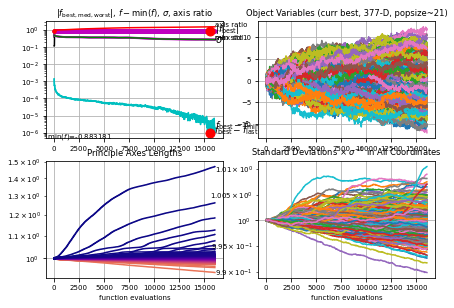

In [9]:
cma_opt_preds = oof_df.copy()
model_cols = oof_df.columns[3:]
# model_cols = [x for x in model_cols if x not in drop_list]
X = cma_opt_preds[model_cols].values

poly = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X = poly.fit_transform(X)

print(model_cols, cma_opt_preds.shape, X.shape)

def get_score(weights, oof=cma_opt_preds):
    weights = np.array(weights)
    cma_opt_preds["prediction"] = (weights * X).sum(axis=1)
    return -score_oof_fast(cma_opt_preds)

init_guess = [1 / X.shape[1]] * X.shape[1]
print("Inital Blend OOF: {:.6f}".format(-get_score(init_guess)))

es = cma.CMAEvolutionStrategy(init_guess, 0.5, {'seed': 2021, "bounds": [None, None], "tolfun": 1e-6, "timeout": "3.0 * 60**2"})
es.optimize(get_score)
print(es.result_pretty())
print("Optimised Blend OOF: {:.6f}".format(-get_score(es.result.xbest)))

ws = es.result.xbest

cma_cv_score = -get_score(es.result.xbest)
cma.plot();

In [10]:
ws = es.result.xbest

cma_cv_score = -get_score(es.result.xbest)
cma_cv_score

0.883181

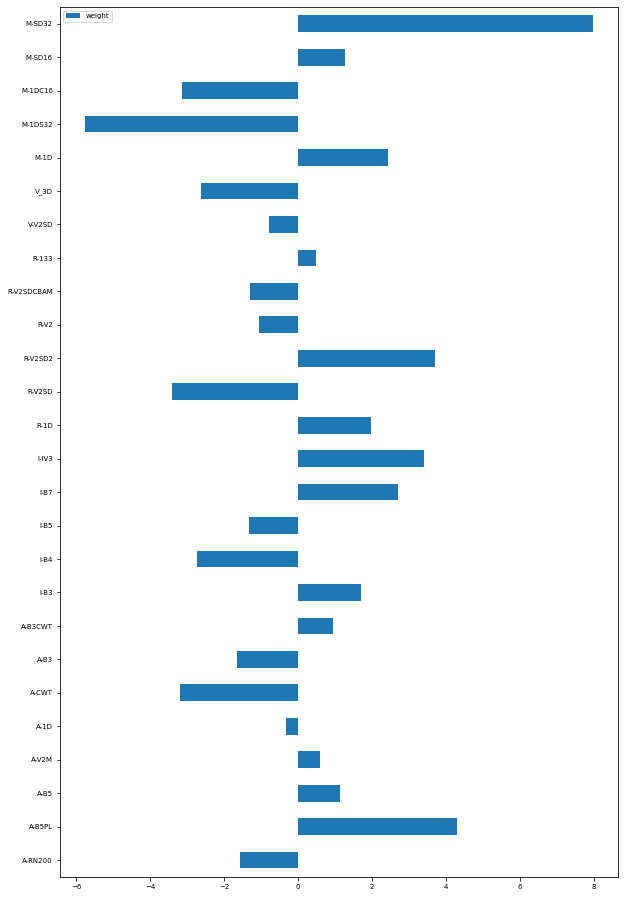

In [11]:
pd.DataFrame(dict(zip(model_cols, ws)), index=["weight"]).T.plot(
    kind="barh", figsize=(10, 16)
);

<AxesSubplot:>

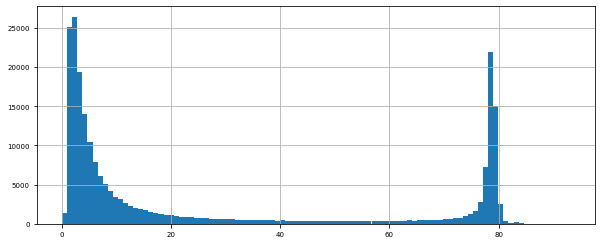

In [12]:
cma_opt_preds["prediction"] = np.sum(ws * X, axis=1)
cma_opt_preds[["id", "target", "fold", "prediction"]].to_csv(
    f"./oof_pred_cma-es_CV{cma_cv_score:.5f}.csv", index=False
)

sub_cma = sub_df[["id"]].copy()
sub_cma["target"] = np.sum(poly.fit_transform(sub_df.iloc[:,1:]) * ws, axis=1)
sub_cma.to_csv(f"./cma-es_ensemble_{cma_cv_score:0.5f}.csv", index=False)
sub_cma["target"].hist(bins=100, figsize=(10, 4))

In [13]:
# 0.882952 Logits
# 0.882911 Rank

# AUC Pruning

In [14]:
class OptimizeAUC:
    """
    Class for optimizing AUC.
    This class is all you need to find best weights for
    any model and for any metric and for any types of predictions.
    With very small changes, this class can be used for optimization of
    weights in ensemble models of _any_ type of predictions
    """

    def __init__(self):
        self.coef_ = 0

    def _auc(self, coef, X, y):
        """
        This functions calulates and returns AUC.
        :param coef: coef list, of the same length as number of models
        :param X: predictions, in this case a 2d array
        :param y: targets, in our case binary 1d array
        """
        x_coef = X * coef
        predictions = np.sum(x_coef, axis=1)

        #         auc_score = roc_auc_score(y, predictions)
        auc_score = fast_auc(y.values, predictions.values)
        return -1.0 * auc_score

    def fit(self, X, y):
        loss_partial = partial(self._auc, X=X, y=y)

        # dirichlet distribution. you can use any distribution you want
        # to initialize the coefficients
        # we want the coefficients to sum to 1
        # initial_coef = np.random.dirichlet(np.ones(X.shape[1]), size=1)
        initial_coef = np.ones(X.shape[1]) / X.shape[1]

        es = cma.CMAEvolutionStrategy(
            initial_coef, 0.5, {"seed": 2021, "bounds": [None, None], "maxfevals": 2500, "tolfun": 1e-6}
        )
        es.optimize(loss_partial)
        self.coef_ = es.result.xbest

    def predict(self, X):
        x_coef = X * self.coef_
        predictions = np.sum(x_coef, axis=1)
        return predictions

In [15]:
def scorer_cma(oofs, col_names, parallel=False):
    
    def score_fold(fold):
        trn_df = oofs.query(f"fold != {fold}")
        val_df = oofs.query(f"fold == {fold}")
        
        bnds = [(-1, 1) for _ in range(len(col_names))]

        opt = OptimizeAUC()
        opt.fit(trn_df[col_names], trn_df["target"])
        y_pred = opt.predict(val_df[col_names])
        return roc_auc_score(val_df["target"], y_pred)
        
    if parallel:
        fold_scores = Parallel(n_jobs=5)(delayed(score_fold)(fold) for fold in range(5))
    else:
        fold_scores = [score_fold(fold) for fold in range(5)]

    return np.mean(fold_scores)

In [16]:
# scorer_cma(oof_df, oof_df.columns[3:], True)

In [17]:
def pruning(oofs, candidates):
    history = []
    score = scorer_cma(oofs, candidates, True)
    print(f"Initial score {score:0.6f}")

    while len(candidates) > 2:
        trial_candidates = [
            candidates[:i] + candidates[i + 1 :] for i, _ in enumerate(candidates)
        ]
        scores = Parallel(n_jobs=32)(delayed(scorer_cma)(oofs, tc) for tc in trial_candidates)
        removed = candidates[np.argmax(scores)]
        del candidates[np.argmax(scores)]
        score = scorer_cma(oofs, candidates, True)
        history.append(
            {
                "models": candidates.copy(),
                "score": score,
                "removed": removed,
            }
        )
        print(
            f"{len(history)} New score {score:0.6f}",
            f"Removed {removed}. {len(candidates)} models",
        )

    history = pd.DataFrame(history)
    history.to_csv("pruning_cma-es.csv", index=False)
    print(history.tail(40))

In [18]:
# pruning(oof_df, list(oof_df.columns[3:]))

```
Initial score 0.882921
1 New score 0.882923 Removed I-B3. 22 models
2 New score 0.882926 Removed A-V2M. 21 models
3 New score 0.882929 Removed A-B5. 20 models
4 New score 0.882931 Removed I-B4. 19 models
5 New score 0.882931 Removed I-IV3. 18 models
6 New score 0.882928 Removed A-RN200. 17 models
7 New score 0.882926 Removed V_3D. 16 models
8 New score 0.882925 Removed R-1D. 15 models
9 New score 0.882921 Removed A-CWT. 14 models
10 New score 0.882916 Removed I-B5. 13 models
11 New score 0.882912 Removed M-1D. 12 models
12 New score 0.882906 Removed A-B3CWT. 11 models
13 New score 0.882898 Removed V-V2SD. 10 models
14 New score 0.882887 Removed A-1D. 9 models
15 New score 0.882875 Removed A-B3. 8 models
16 New score 0.882866 Removed R-V2SD2. 7 models
```